#Zadanie 7 (7 pkt)
Celem zadania jest zaimplementowanie dwóch wersji naiwnego klasyfikatora Bayesa.
* W pierwszej wersji należy dokonać dyskretyzacji danych - przedział wartości każdego atrybutu dzielimy na cztery równe przedziały i każdej ciągłej wartości atrybutu przypisujemy wartość dyskretną wynikająca z przynależności do danego przedziału.
* W drugiej wersji wartości likelihood wyliczamy z rozkładów normalnych o średnich i odchyleniach standardowych wynikających z wartości atrybutów.
Trening i test należy przeprowadzić dla zbioru Iris, tak jak w przypadku zadania z drzewem klasyfikacyjnym. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania klasyfikatorów dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Dyskretyzacja danych - **0.5 pkt**
* Implementacja funkcji rozkładu normalnego o zadanej średniej i odchyleniu standardowym. - **0.5 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych dyskretnych. - **2.0 pkt**
* Implementacja naiwnego klasyfikatora Bayesa dla danych ciągłych. - **2.5 pkt**
* Przeprowadzenie eksperymentów, wnioski i sposób ich prezentacji. - **1.5 pkt**

In [166]:
from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

In [150]:
class NaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        discrete_xtrain = self.data_discretization(train_features)
        labels = np.unique(train_classes)
        labels_count = Counter(train_classes)

        for label in labels:
            self.priors[label] = labels_count[label] / len(train_classes)

            label_dict = {}
            mask = train_classes == label
            for i in range(discrete_xtrain.shape[1]):
                attribute = discrete_xtrain[mask, i]
                attribute_counter = Counter(attribute)
                attribute_dict = {x: 0 for x in np.unique(discrete_xtrain)}
                for unique_value, number in attribute_counter.items():
                    attribute_dict[unique_value] = number / labels_count[label]

                label_dict[i] = attribute_dict
            self.likelihoods[label] = label_dict

    @staticmethod
    def data_discretization(data: np.ndarray) -> np.ndarray:
        intervals = 4

        discrete_array = np.zeros(data.shape)
        for i in range(data.shape[1]):
            min_value = np.min(data[:, i])
            max_value = np.max(data[:, i])
            interval = (max_value - min_value) / intervals
            for j in range(data.shape[0]):
                discrete_array[j, i] = min((data[j, i] - min_value) // interval,
                                           intervals - 1)

        return discrete_array

    def predict(self, sample):
        predictions = {}
        for label, prior in self.priors.items():
            value = 1
            for i, att_value in enumerate(sample):
                try:
                    value *= self.likelihoods[label][i][att_value]
                except KeyError:
                    value *= 0
            predictions[label] = value

        return max(predictions, key=predictions.get)


class GaussianNaiveBayes:
    def __init__(self):
        self.priors = {}
        self.likelihoods = {}

    def build_classifier(self, train_features, train_classes):
        labels = np.unique(train_classes)
        labels_count = Counter(train_classes)

        for label in labels:
            self.priors[label] = labels_count[label] / len(train_classes)

            label_dict = {}
            mask = train_classes == label

            for i in range(train_features.shape[1]):
                attribute = train_features[mask, i]

                attribute_mean = np.mean(attribute)
                attribute_std = np.std(attribute)
                attribute_dict = {"mean": attribute_mean, "std": attribute_std}

                label_dict[i] = attribute_dict
            self.likelihoods[label] = label_dict

    @staticmethod
    def normal_dist(x, mean, std):
        if std == 0:
            return 0
        else:
            prob_density = (np.pi * std) * np.exp(-0.5 * ((x - mean) / std) ** 2)
        return prob_density

    def predict(self, sample):
        predictions = {}
        for label, prior in self.priors.items():
            value = 1
            for i, att_value in enumerate(sample):
                att_mean = self.likelihoods[label][i]["mean"]
                att_std = self.likelihoods[label][i]["std"]
                value *= self.normal_dist(att_value, att_mean, att_std)
            predictions[label] = value

        return max(predictions, key=predictions.get)

In [151]:
def generate_prediction_tuples(classifier, x_data: np.ndarray, y_data: np.ndarray) -> List[Tuple[int, int]]:
    prediction_and_label = []
    for data, label in zip(x_data, y_data):
        pred = classifier.predict(data)
        prediction_and_label.append((pred, label))
    return prediction_and_label

def measure_accuracy(classifier, x_data: np.ndarray, y_data: np.ndarray) -> float:
    predictions_list = generate_prediction_tuples(classifier, x_data, y_data)
    predicted_successfully = sum([1 for x, y in predictions_list if x == y])
    return predicted_successfully / len(predictions_list)


# Sprawdzenie klasyfikatorow dla danych testowych z zadanym podziałem
## Naiwny klasyfikator Bayesa

In [152]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

In [153]:
bayes = NaiveBayes()
bayes.build_classifier(x_train, y_train)

In [154]:
discrete_x_test = bayes.data_discretization(x_test)
predictions_vs_label_list = generate_prediction_tuples(bayes, discrete_x_test, y_test)
for pred, label in predictions_vs_label_list:
    print(pred, label)

2 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2


In [155]:
accuracy = measure_accuracy(bayes, discrete_x_test, y_test)

print(f"Naive Bayes Classifier Accuracy: {accuracy*100:.2f}%")

Naive Bayes Classifier Accuracy: 93.33%


## Gaussowski naiwny klasyfikator Bayesa

In [156]:
gaussian_naive_bayes = GaussianNaiveBayes()
gaussian_naive_bayes.build_classifier(x_train, y_train)

In [157]:
predictions_vs_label_list_gauss = generate_prediction_tuples(gaussian_naive_bayes, x_test, y_test)
for pred, label in predictions_vs_label_list_gauss:
    print(pred, label)

1 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2


In [158]:
accuracy_gauss = measure_accuracy(gaussian_naive_bayes, x_test, y_test)

print(f"Gaussian Naive Bayes Classifier Accuracy: {accuracy_gauss*100:.2f}%")

Gaussian Naive Bayes Classifier Accuracy: 100.00%


# Wpływ podziału zbioru danych na skuteczność klasyfikatorów

In [159]:
def generate_plot(x, y, dataset: str, tries=100, random_state=None):
    accuracies = []
    split_values = []
    for test_size_mult in range(1, 20):
        naive_temp_accuracy = []
        gauss_temp_accuracy = []
        for i in range(tries):
            if random_state is None:
                x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size=0.5*test_size_mult/10)
            else:
                x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size=0.5*test_size_mult/10, random_state=random_state)
            naive_1 = NaiveBayes()
            gauss_1 = GaussianNaiveBayes()

            naive_1.build_classifier(x_train_1, y_train_1)
            gauss_1.build_classifier(x_train_1, y_train_1)

            discrete_x_test_1 = naive_1.data_discretization(x_test_1)
            naive_temp_accuracy.append(measure_accuracy(naive_1, discrete_x_test_1, y_test_1))
            gauss_temp_accuracy.append(measure_accuracy(gauss_1, x_test_1, y_test_1))

        accuracies.append((sum(naive_temp_accuracy)/tries, sum(gauss_temp_accuracy)/tries))
        split_values.append(0.5*test_size_mult/10)

    plt.plot(split_values,[x[0]*100 for x in accuracies],'o-', label=f"Naive Bayes")
    plt.plot(split_values,[x[1]*100 for x in accuracies],'o-', label=f"Gaussian Naive Bayes")


    plt.grid()
    plt.legend()
    if random_state is None:
        plt.title(f"Precyzja przewidywań zbioru {dataset} dla różnej wielkości zbioru treningowego")
    else:
        plt.title(f"Precyzja przewidywań zbioru {dataset} dla różnej wielkości zbioru treningowego dla random_state={random_state}")
    plt.ylabel("Skuteczność [%]")
    plt.xlabel("Wielkość zbioru testowego w porównaniu do całości zbioru")
    plt.show()

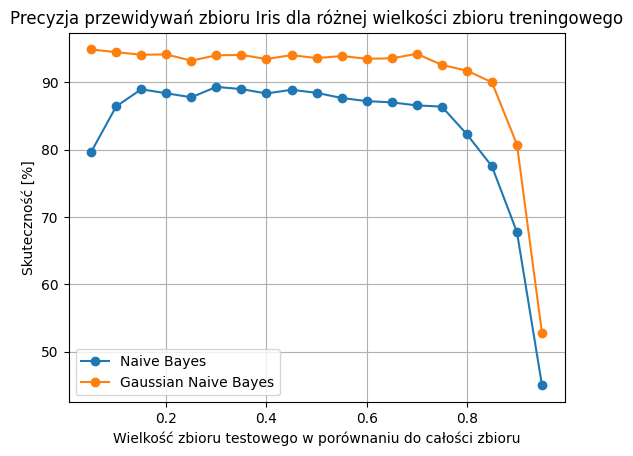

In [160]:
generate_plot(x, y, tries=100, dataset="Iris")

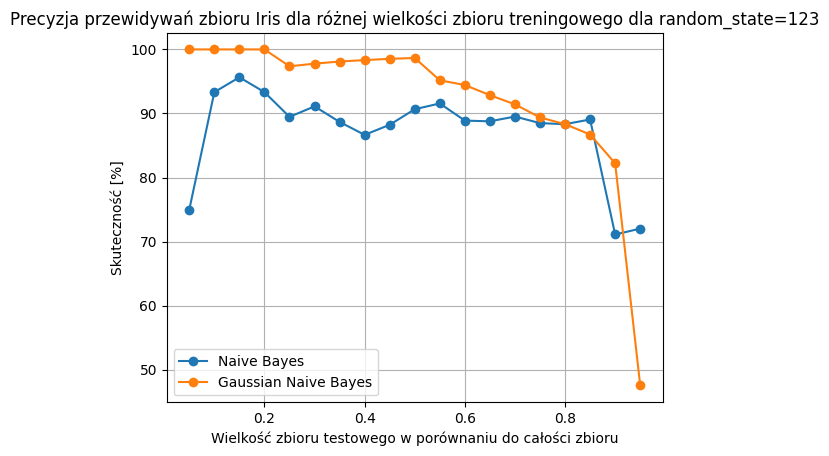

In [161]:
generate_plot(x, y, tries=1, random_state=123, dataset="Iris")

# Skuteczność naiwnego klasyfikatora Bayesa oraz gaussowskiego naiwnego klasyfikatora bayesa dla zbioru Wine

In [164]:
wine = load_wine()
x_wine = wine.data
y_wine = wine.target

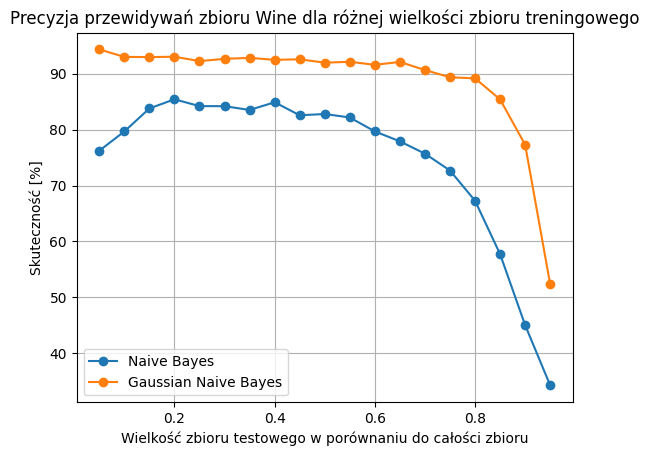

In [165]:
generate_plot(x_wine, y_wine, tries=100, dataset="Wine")

# Wnioski

Po przetestowaniu klasyfikatorów NaiveBayes oraz GaussNaiveBayes można zauważyć, że generalnie klasyfikator wykorzystujący do generowania prawdopodobieństwa warunkowego $P(x_i|C_i)$ wypada lepiej od drugiego klasyfikatora wykorzystującego dyskretyzację danych. Wynik taki nie powinien nas dziwić, ponieważ wiele cech obiektów badawczych ma rozkład normalny.

W przypadku klasyfikatora NaiveBayes z dyskretyzacją danych średnia wartość skuteczności na danych testowych (na 100 próbach z danym podziałem zbioru na zbiór treningowy i testowy) nie była w stanie przekroczyć wartości 90%. Z drugiej strony klasyfikator GaussianNaiveBayes cechował się skutecznością powyżej 95% aż do wartości podziału zbioru treningowego do testowego 25:75.

Zarówno dla klasyfikatora NaiveBayes jak i GaussianNaiveBayes widoczny był wyraźny spadek skuteczności od podziału 20:80 wraz ze wzrostem wielkości zbioru testowego względem zbioru treningowego.

Co ciekawe spadek wartośći skuteczności na zbiorze Iris wygląda bardzo podobnie zarówno dla klasyfikatorze wykorzystującym algorytm drzew losowych ID3 jak i klasyfikatorów opartych na twierdzeniu Bayesa (NaiveBayes, GaussianNaiveBayes).

Dla zbioru Wine wyniki skuteczności dla obu klasyfikatorów były podobne do wartości zaobserwowanych na zbiorze Iris.
